In [20]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import cross_val_score
from scipy.sparse import csr_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.svm import SVC
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.ensemble import VotingClassifier

## Read Data

In [2]:
dom1 = []
dom2 = []
Test_set = []
with open('../data/domain1_train.json', 'r') as file:
    for line in file:
        dom1.append(json.loads(line))
        
with open('../data/domain2_train.json', 'r') as file:
    for line in file:
        dom2.append(json.loads(line))
        
sam = pd.read_csv("../data/sample.csv")

with open('../data/test_set.json', 'r') as file:
    for line in file:
        Test_set.append(json.loads(line))
        
dom1 = pd.DataFrame.from_dict(dom1)
dom2 = pd.DataFrame.from_dict(dom2)
dom2 = dom2[dom2['text'].apply(len) > 0]
Test_set = pd.DataFrame.from_dict(Test_set)

# human as model 8, dom1 AI as model 7
dom1['model'] = np.where(dom1['label'] == 1, 8, 7)
dom2["model"] = dom2["model"].replace(np.nan, 8)

#### Remove Words with 1 frequency

In [3]:
def word_freq(domain):
    counter = Counter()
    for text in domain['text']:
        counter = dict(Counter(text) + Counter(counter))
    
    # Find tokens with frequency equal to 1
    word_del = [token for token, count in counter.items() if count == 1]

    return word_del


def drop_min_freq(text, del_word):
    # remove word (fre=1) from list of each row
    return [word for word in text if word not in del_word]

def renew_dataset(dataset, del_word):
    # apple fuction to ['text'] row
    dataset['text'] = dataset['text'].apply(lambda x: drop_min_freq(x, del_word))
    return dataset

dom1 = renew_dataset(dom1, word_freq(dom1))
dom2 = renew_dataset(dom2, word_freq(dom2))
Test_set = renew_dataset(Test_set, word_freq(Test_set))

## Resample

#### full dom1 + even dom2

In [4]:
dom2_0 = dom2.loc[dom2['label']==0]
dom2_1 = dom2.loc[dom2['label']==1]
# select model number in dom2 by label1 number in dom2 / AI model number
length_dom2_1 = len(dom2_1)
mol_num = len(dom2['model'].value_counts())
least_mol_num = length_dom2_1/(mol_num-1)
sam_dom2_0 = dom2_0.groupby('model').apply(lambda x: x.sample(n=int(least_mol_num)))
sam_dom2_0.reset_index(drop=True, inplace=True)
# concate
dom2_even = pd.concat([dom2_1, sam_dom2_0])
# as label is even in dom1, just merge selected dom2 + full dom1
df = pd.concat([dom1, dom2_even])
df = df.sample(frac=1).reset_index(drop=True)

## Vectorizer

#### Sparse

In [5]:
def to_sparse_matrix(sequences, vocab_size):
    indptr = [0]
    indices = []
    data = []
    for seq in sequences:
        feature_counter = {}
        for index in seq:
            if index != 0:  # Skip 0s, other words
                if index not in feature_counter:
                    feature_counter[index] = 1
                else:
                    feature_counter[index] += 1
        indices.extend(feature_counter.keys())
        data.extend(feature_counter.values())
        indptr.append(len(indices))
    return csr_matrix((data, indices, indptr), dtype=int, shape=(len(sequences), vocab_size + 1))
vocab_size = 4999
# sparse text part
df_text_vec = to_sparse_matrix(df['text'], vocab_size)
Test_text_vec = to_sparse_matrix(Test_set['text'], vocab_size)
# y for model
y_df = df['label']

## Text Sparse Matrix Feature Selection

#### Select Kbest for SVM (Best model)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % con

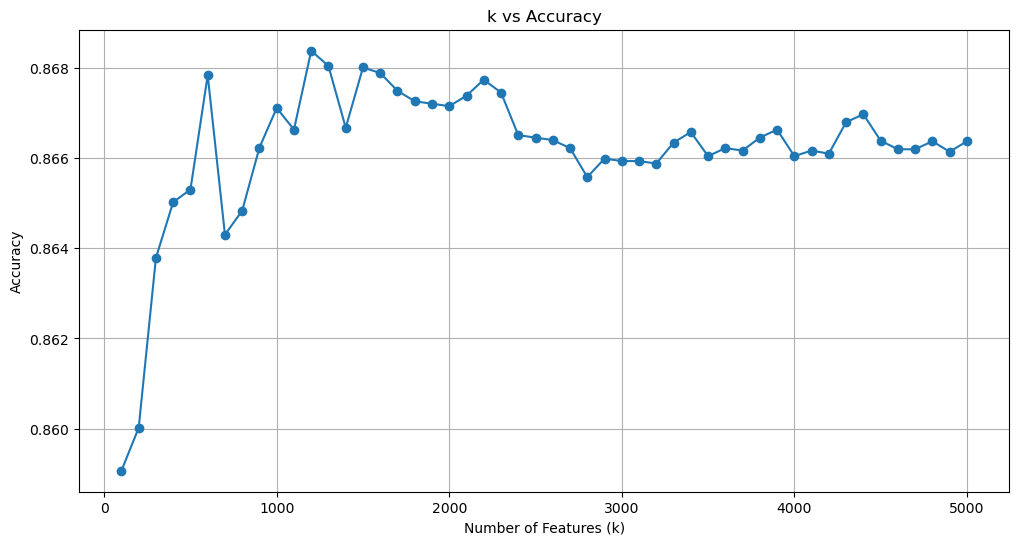

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df_text_vec, y_df, test_size=0.2, random_state=42)
k_values = []
accuracies = []

for k in range(100, (X_train.shape[1] + 1),100):
    # Apply SelectKBest class to extract top k best features
    best_features = SelectKBest(score_func=f_classif, k=k)
    X_train_kbest = best_features.fit_transform(X_train, y_train)
    X_test_kbest = best_features.transform(X_test)
    # train classifier
    classifier = SVC()
    classifier.fit(X_train_kbest, y_train)
    # Predict
    y_pred = classifier.predict(X_test_kbest)
    acc = f1_score(y_test, y_pred)
    k_values.append(k)
    accuracies.append(acc)
    
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-')
plt.xlabel('Number of Features (k)')
plt.ylabel('Accuracy')
plt.title('k vs Accuracy')
plt.grid(True)
plt.savefig('Kbest.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
selector = SelectKBest(chi2, k=1200)
X_select = selector.fit_transform(df_text_vec, y_df)

X_Test_select= selector.transform(Test_text_vec)

## Add New Features

In [7]:
# Add length of each text as new feature
df['text_length'] = df['text'].apply(lambda x: len(x))
Test_set['text_length'] = Test_set['text'].apply(lambda x: len(x))

minimax_scale = MinMaxScaler()
df['text_length'] = minimax_scale.fit_transform(df[['text_length']])
Test_set['text_length'] = minimax_scale.fit_transform(Test_set[['text_length']])

## Aggregation

In [8]:
length_df = pd.DataFrame(df['text_length'])
Test_length_df = pd.DataFrame(Test_set['text_length'])
# X for model and kaggle
X_final = hstack([length_df, X_select], format='csr')
X_Test_final = hstack([Test_length_df, X_Test_select], format='csr')

## SVM

#### Hyperparameter Tunning

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_df, test_size=0.2, random_state=42)

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]}#,'kernel': ['rbf', 'poly', 'sigmoid']
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)
print(grid.best_estimator_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................................C=0.1, gamma=1; total time=  49.3s
[CV] END .....................................C=0.1, gamma=1; total time=  49.2s
[CV] END .....................................C=0.1, gamma=1; total time=  48.9s
[CV] END .....................................C=0.1, gamma=1; total time=  46.1s
[CV] END .....................................C=0.1, gamma=1; total time=  46.5s
[CV] END ...................................C=0.1, gamma=0.1; total time=  35.9s
[CV] END ...................................C=0.1, gamma=0.1; total time=  36.5s
[CV] END ...................................C=0.1, gamma=0.1; total time=  35.9s
[CV] END ...................................C=0.1, gamma=0.1; total time=  36.5s
[CV] END ...................................C=0.1, gamma=0.1; total time=  36.5s
[CV] END ..................................C=0.1, gamma=0.01; total time=  17.0s
[CV] END ..................................C=0.1

In [10]:
print(grid.best_estimator_)

SVC(C=10, gamma=0.01)


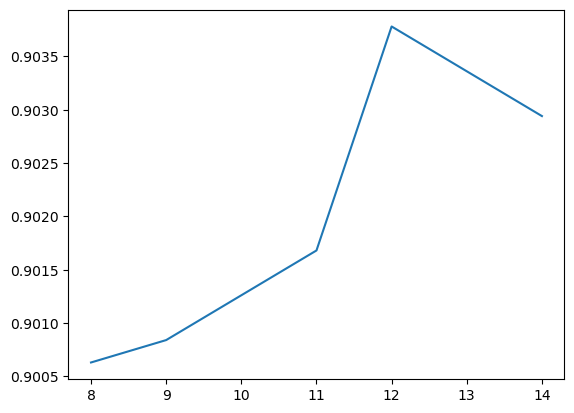

In [23]:
C_range = list(range(8, 15))
scores = []
for i in C_range:
    clf = svm.SVC(C=i, gamma=0.01)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))
plt.plot(C_range, scores)
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('C vs Accuracy')
plt.savefig('SVM_c.png', dpi=300, bbox_inches='tight')
plt.show()

#### Split Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_df, test_size=0.2, random_state=42)

#### Train

In [26]:
model_svm = svm.SVC(C=12, gamma=0.01).fit(X_train, y_train) #decision_function_shape='ovr'

#### Evaluation

#### Cross-validation

In [14]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(model_svm, X_final, y_df, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.883 (0.006)


#### Train & Test Accuracy

In [ ]:
y_pred_train = model_svm.predict(X_train)
print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
y_pred_test = model_svm.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))

Train Accuracy: 0.9151696606786427
Train f1: 0.9177070063694267
Test Accuracy: 0.8724789915966387
Test f1: 0.8724789915966387


#### Confusion Matrix

In [ ]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87      2392
           1       0.85      0.90      0.88      2368

    accuracy                           0.87      4760
   macro avg       0.87      0.87      0.87      4760
weighted avg       0.87      0.87      0.87      4760



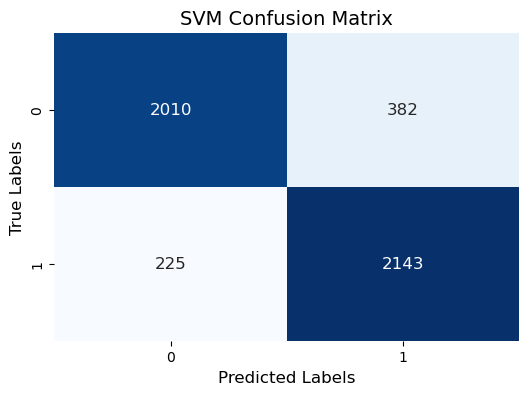

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 12})
# Set labels for axes
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('SVM Confusion Matrix', fontsize=14)
plt.savefig('cm.png', dpi=300, bbox_inches='tight')
plt.show()

## Ensemble Learning (SVM Voting)

#### Data Processing for Dom1,2

In [39]:
# apply processing to dom1
dom1_text_vec = to_sparse_matrix(dom1['text'], vocab_size)
y_dom1 = dom1['label']
selector = SelectKBest(chi2, k=1200)
X_dom1_select = selector.fit_transform(dom1_text_vec, y_dom1)
dom1['text_length'] = dom1['text'].apply(lambda x: len(x))
dom1['text_length'] = minimax_scale.fit_transform(dom1[['text_length']])
length_dom1 = pd.DataFrame(dom1['text_length'])
X_dom1_final = hstack([length_dom1, X_dom1_select], format='csr')

# apply processing to dom2_even
dom2even_text_vec = to_sparse_matrix(dom2_even['text'], vocab_size)
y_dom2even = dom2_even['label']
selector = SelectKBest(chi2, k=1200)
X_dom2even_select = selector.fit_transform(dom2even_text_vec, y_dom2even)
dom2_even['text_length'] = dom2_even['text'].apply(lambda x: len(x))
dom2_even['text_length'] = minimax_scale.fit_transform(dom2_even[['text_length']])
length_dom2even = pd.DataFrame(dom2_even['text_length'])
X_dom2even_final = hstack([length_dom2even, X_dom2even_select], format='csr')

#### Train

In [40]:
svm1 = SVC(gamma=0.01, C=12)
svm1.fit(X_dom1_final, y_dom1) 

svm2 = SVC(gamma=0.01, C=12)
svm2.fit(X_dom2even_final, y_dom2even) 

# Create a VotingClassifier to combine the two SVMs
combined_svm = VotingClassifier(estimators=[('svm1', svm1), ('svm2', svm2)], voting='hard')
# Train the combined classifier on the full training set
combined_svm.fit(X_train, y_train)

VotingClassifier(estimators=[('svm1', SVC(C=12, gamma=0.01)),
                             ('svm2', SVC(C=12, gamma=0.01))])

#### Evaluation

#### Cross-validation

In [57]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(combined_svm, X_final, y_df, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.884 (0.005)


#### Train & Test Accuracy

In [50]:
y_pred_train = combined_svm.predict(X_train)
y_pred_test = combined_svm.predict(X_test)
print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))

Train Accuracy: 0.9596596281121966
Test Accuracy: 0.8897058823529411


#### Confusion Matrix

In [51]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      2424
           1       0.86      0.93      0.89      2336

    accuracy                           0.89      4760
   macro avg       0.89      0.89      0.89      4760
weighted avg       0.89      0.89      0.89      4760



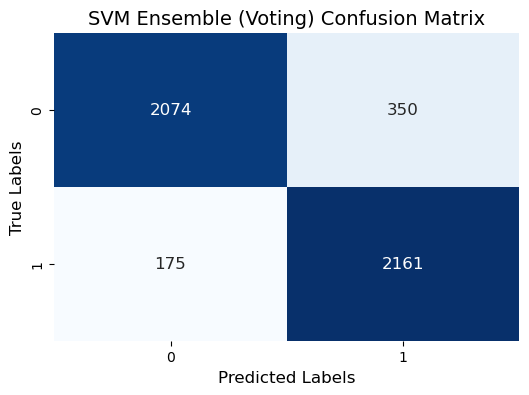

In [58]:
cm = confusion_matrix(y_test, y_pred_test)
# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 12})
# Set labels for axes
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('SVM Ensemble (Voting) Confusion Matrix', fontsize=14)
plt.savefig('cm_vote.png', dpi=300, bbox_inches='tight')
plt.show()

## Output Kaggle

In [59]:
test_pre = combined_svm.predict(X_Test_final)
result = pd.DataFrame({
    'class': test_pre,
})
result['id'] = result.index
result = result[['id'] + [col for col in result.columns if col != 'id']]
result['class'].value_counts()

class
1    563
0    437
Name: count, dtype: int64

In [61]:
#result.to_csv('result_svm.csv', index=False)